In [14]:
import os
import numpy as np
import pandas as pd
import zipfile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
full_data=pd.read_csv('Data.csv')
test_data_X = pd.read_csv('test.csv')
test_data_y =pd.read_csv('test_labels.csv')

In [17]:
full_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [18]:
print(f"There are {len(full_data)} observations in full data.")

There are 159571 observations in full data.


In [19]:
test_data_X.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [20]:
test_data_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [22]:
# Merging the X and y part together
test_dataframe = pd.merge(test_data_X, test_data_y, how="inner", on="id")

# Remove all the rows having missing values (-1)
test_dataframe = test_dataframe[test_dataframe["toxic"] != -1].reset_index(drop=True)

test_dataframe.sample(5) 

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
11151,2c91408edc033de9,== Wrong colors == \n\n Correct: the metro lin...,0,0,0,0,0,0
25832,66ce5c597b667468,cheader cheese is very jolly A FUCKK,1,0,1,0,1,0
31886,7f46befa0fb5026a,==A riddle== \n I ponder a riddle for the few ...,0,0,0,0,0,0
1361,05ba7e8f954be065,""":::Hi Giggy! Puny 'shonen post pile of new fe...",1,0,0,0,0,0
9020,24334625e636ddd1,faty faty faty faty cow balls are fucking your...,1,0,1,0,1,0


In [23]:
print(f"We have {len(test_dataframe)} observations in test data.")

We have 63978 observations in test data.


In [24]:
del test_data_X
del test_data_y

In [25]:
full_data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [26]:
full_data["comment_text"].values

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

In [27]:
full_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [28]:
# Convert the dataframes into tensorflow Dataset objects

train_data = tf.data.Dataset.from_tensor_slices(
    (
        full_data["comment_text"].tolist(), 
        full_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values.tolist()
    )
)

test_data = tf.data.Dataset.from_tensor_slices(
    (
        test_dataframe["comment_text"].tolist(), 
        test_dataframe[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values.tolist()
    )
)

In [29]:
batch_size = 16

train_data = train_data.cache().shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.cache().batch(batch_size)

In [30]:
max_tokens = 100000

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    standardize='lower_and_strip_punctuation',
    output_mode="int",
    output_sequence_length=1800
)

text_vectorization.adapt(full_data["comment_text"].tolist())


In [31]:
# Remove the unnecessary data

del full_data
del test_dataframe

In [32]:
model = Sequential([
    text_vectorization,
    layers.Embedding(max_tokens+1, 32),
    layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(6, activation="sigmoid")
])

In [33]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=metrics.BinaryAccuracy()
)

In [34]:
train_split = 0.8

train_data = train_data.take(int(len(train_data) * train_split))
valid_data = train_data.skip(int(len(train_data) * train_split))

In [35]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5, 
        restore_best_weights=True, 
        start_from_epoch=1, 
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", 
        factor=0.5, 
        patience=3, 
        verbose=1, 
        min_lr=1e-6
    )
]

In [37]:
model_history = model.fit(
    train_data,
    epochs=15,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_data
).history

Epoch 1/15
7978/7979 [============================>.] - ETA: 0s - loss: 0.0607 - binary_accuracy: 0.9796

2024-02-23 17:26:37.570339: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - 3408s 427ms/step - loss: 0.0607 - binary_accuracy: 0.9796 - val_loss: 0.0442 - val_binary_accuracy: 0.9834 - lr: 0.0010
Epoch 2/15


2024-02-23 17:28:19.714157: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7978/7979 [============================>.] - ETA: 1s - loss: 0.0445 - binary_accuracy: 0.9831

2024-02-23 20:33:24.770922: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - ETA: 0s - loss: 0.0445 - binary_accuracy: 0.9831

2024-02-23 20:35:16.245508: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - 11217s 1s/step - loss: 0.0445 - binary_accuracy: 0.9831 - val_loss: 0.0352 - val_binary_accuracy: 0.9865 - lr: 0.0010
Epoch 3/15
7978/7979 [============================>.] - ETA: 0s - loss: 0.0379 - binary_accuracy: 0.9852

2024-02-23 21:35:42.941611: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - ETA: 0s - loss: 0.0379 - binary_accuracy: 0.9852

2024-02-23 21:37:21.641032: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - 3725s 467ms/step - loss: 0.0379 - binary_accuracy: 0.9852 - val_loss: 0.0309 - val_binary_accuracy: 0.9894 - lr: 0.0010
Epoch 4/15
7978/7979 [============================>.] - ETA: 0s - loss: 0.0326 - binary_accuracy: 0.9872

2024-02-23 22:48:58.156543: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - ETA: 0s - loss: 0.0326 - binary_accuracy: 0.9872

2024-02-23 22:50:37.582474: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - 4396s 551ms/step - loss: 0.0326 - binary_accuracy: 0.9872 - val_loss: 0.0261 - val_binary_accuracy: 0.9902 - lr: 0.0010
Epoch 5/15
7978/7979 [============================>.] - ETA: 0s - loss: 0.0280 - binary_accuracy: 0.9890

2024-02-24 00:43:17.016076: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - ETA: 0s - loss: 0.0280 - binary_accuracy: 0.9890

2024-02-24 00:44:56.586465: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - 6859s 860ms/step - loss: 0.0280 - binary_accuracy: 0.9890 - val_loss: 0.0222 - val_binary_accuracy: 0.9922 - lr: 0.0010
Epoch 6/15
7978/7979 [============================>.] - ETA: 3s - loss: 0.0245 - binary_accuracy: 0.9906

2024-02-24 09:25:21.018457: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - ETA: 0s - loss: 0.0245 - binary_accuracy: 0.9906

2024-02-24 09:27:00.844095: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - 31324s 4s/step - loss: 0.0245 - binary_accuracy: 0.9906 - val_loss: 0.0186 - val_binary_accuracy: 0.9934 - lr: 0.0010
Epoch 7/15
7978/7979 [============================>.] - ETA: 13s - loss: 0.0216 - binary_accuracy: 0.9919

2024-02-25 15:33:53.890399: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - 108518s 14s/step - loss: 0.0216 - binary_accuracy: 0.9919 - val_loss: 0.0289 - val_binary_accuracy: 0.9922 - lr: 0.0010
Epoch 8/15


2024-02-25 15:35:38.919526: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7978/7979 [============================>.] - ETA: 0s - loss: 0.0189 - binary_accuracy: 0.9930

2024-02-25 16:31:00.550351: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - ETA: 0s - loss: 0.0189 - binary_accuracy: 0.9930

2024-02-25 16:32:41.163735: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - 3423s 429ms/step - loss: 0.0189 - binary_accuracy: 0.9930 - val_loss: 0.0156 - val_binary_accuracy: 0.9946 - lr: 0.0010
Epoch 9/15
7978/7979 [============================>.] - ETA: 1s - loss: 0.0163 - binary_accuracy: 0.9939

2024-02-25 18:47:21.233108: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - ETA: 0s - loss: 0.0163 - binary_accuracy: 0.9939

2024-02-25 18:49:00.019245: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - 8179s 1s/step - loss: 0.0163 - binary_accuracy: 0.9939 - val_loss: 0.0149 - val_binary_accuracy: 0.9946 - lr: 0.0010
Epoch 10/15
7978/7979 [============================>.] - ETA: 0s - loss: 0.0148 - binary_accuracy: 0.9945

2024-02-25 19:44:42.974304: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - ETA: 0s - loss: 0.0148 - binary_accuracy: 0.9945

2024-02-25 19:46:21.319680: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - 3441s 431ms/step - loss: 0.0148 - binary_accuracy: 0.9945 - val_loss: 0.0118 - val_binary_accuracy: 0.9958 - lr: 0.0010
Epoch 11/15
7978/7979 [============================>.] - ETA: 0s - loss: 0.0128 - binary_accuracy: 0.9951

2024-02-25 20:42:02.663542: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - 3442s 431ms/step - loss: 0.0128 - binary_accuracy: 0.9951 - val_loss: 0.0146 - val_binary_accuracy: 0.9952 - lr: 0.0010
Epoch 12/15


2024-02-25 20:43:43.861897: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7978/7979 [============================>.] - ETA: 0s - loss: 0.0115 - binary_accuracy: 0.9956

2024-02-25 22:13:47.086114: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - ETA: 0s - loss: 0.0115 - binary_accuracy: 0.9956

2024-02-25 22:15:26.694713: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - 5503s 690ms/step - loss: 0.0115 - binary_accuracy: 0.9956 - val_loss: 0.0107 - val_binary_accuracy: 0.9962 - lr: 0.0010
Epoch 13/15
7978/7979 [============================>.] - ETA: 0s - loss: 0.0101 - binary_accuracy: 0.9963

2024-02-25 23:10:20.806602: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - ETA: 0s - loss: 0.0101 - binary_accuracy: 0.9963

2024-02-25 23:12:00.276175: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - 3394s 425ms/step - loss: 0.0101 - binary_accuracy: 0.9963 - val_loss: 0.0102 - val_binary_accuracy: 0.9970 - lr: 0.0010
Epoch 14/15
7978/7979 [============================>.] - ETA: 0s - loss: 0.0092 - binary_accuracy: 0.9966

2024-02-26 00:06:52.686264: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - ETA: 0s - loss: 0.0092 - binary_accuracy: 0.9966

2024-02-26 00:08:32.631654: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - 3392s 425ms/step - loss: 0.0092 - binary_accuracy: 0.9966 - val_loss: 0.0078 - val_binary_accuracy: 0.9973 - lr: 0.0010
Epoch 15/15
7978/7979 [============================>.] - ETA: 0s - loss: 0.0083 - binary_accuracy: 0.9970

2024-02-26 01:03:23.227885: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - ETA: 0s - loss: 0.0083 - binary_accuracy: 0.9970

2024-02-26 01:05:02.509741: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


7979/7979 [==============================] - 3390s 425ms/step - loss: 0.0083 - binary_accuracy: 0.9970 - val_loss: 0.0070 - val_binary_accuracy: 0.9976 - lr: 0.0010


In [38]:
model.evaluate(test_data)

3999/3999 [==============================] - 254s 64ms/step - loss: 0.1398 - binary_accuracy: 0.9587


[0.13980212807655334, 0.958696722984314]

In [39]:
import matplotlib.pyplot as plt

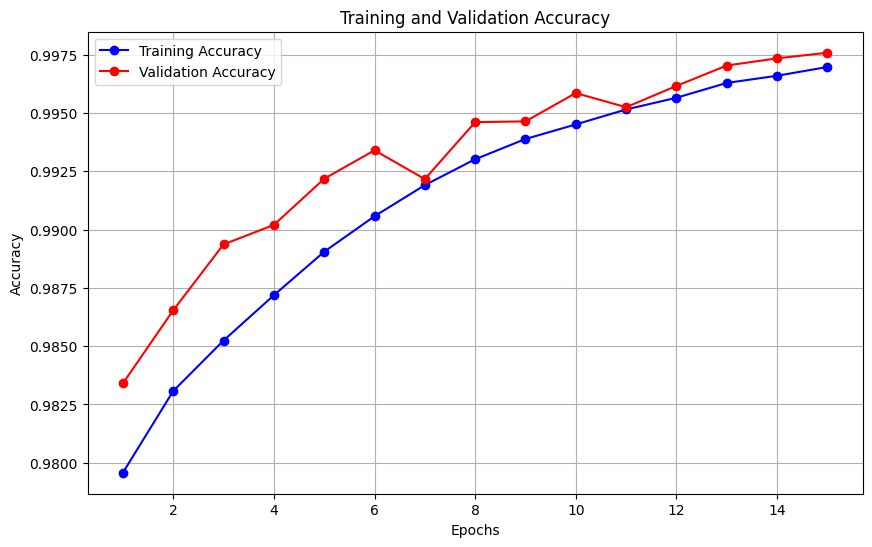

In [40]:
train_accuracy = model_history['binary_accuracy']
val_accuracy = model_history['val_binary_accuracy']

# Creating a range of epochs for x-axis
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
model.save('toxicity', save_format='tf')

INFO:tensorflow:Assets written to: toxicity/assets


INFO:tensorflow:Assets written to: toxicity/assets


In [42]:
text = input()
predictions = model.predict(np.array([text])) > 0.5
prediction_text = ""
for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    prediction_text += f"{col:<{20}}: {predictions[0][i]:<{5}}\n"
print(prediction_text)

1/1 [==============================] - 1s 543ms/step
toxic               : 1    
severe_toxic        : 0    
obscene             : 0    
threat              : 1    
insult              : 0    
identity_hate       : 0    

